In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA vs Autoencoder vs Orthogonal Encoder (All Linear)

In [2]:
import numpy as np

from sklearn import decomposition
from sklearn import datasets
from sklearn import preprocessing

import torch
from torch import nn
from orthonet import jacob

In [3]:
def create_two_mvn(n, dim=10):
    
    nh = int(n/2)
    mu = np.zeros(dim)
    
    sig1 = np.identity(10) / 10.0
    sig1[1,2] = 0.9
    sig1[2,1] = 0.9
    sig1[1,1] = 1.0
    sig1[2,2] = 1.0
    
    sig2 = np.identity(10) / 10.0
    sig2[1,2] = -0.9
    sig2[2,1] = -0.9
    sig2[1,1] =  1.0
    sig2[2,2] =  1.0
    
    s1 = np.random.multivariate_normal(mu, sig1, nh)
    s2 = np.random.multivariate_normal(mu, sig2, nh)
    
    data  = np.concatenate([s1, s2])
    label = np.concatenate([np.zeros(nh), 
                            np.ones(nh)]).astype(np.int)
    
    return data, label

4.055
(150, 4)


<IPython.core.display.Javascript object>


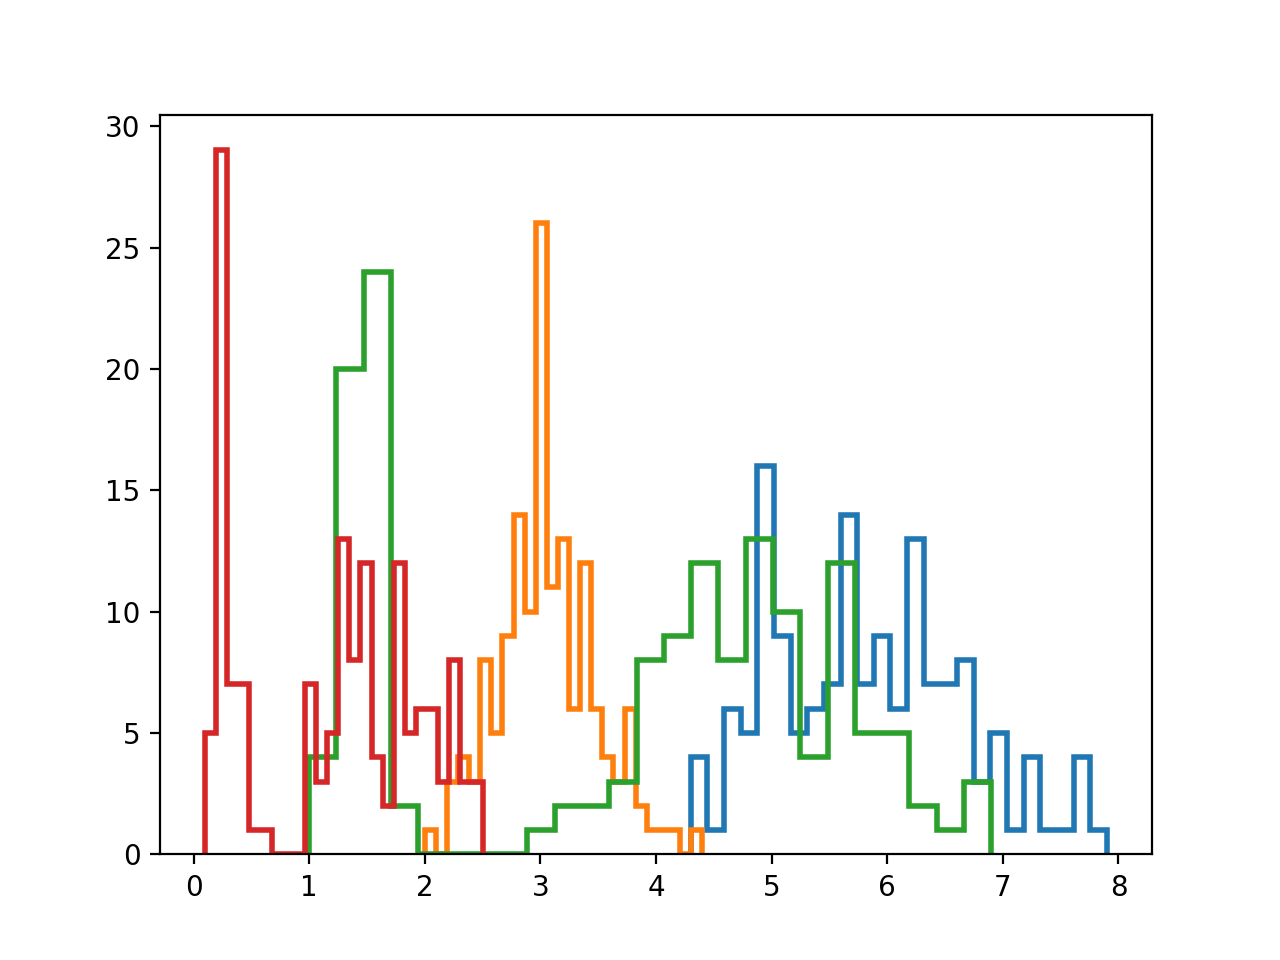

<IPython.core.display.Javascript object>


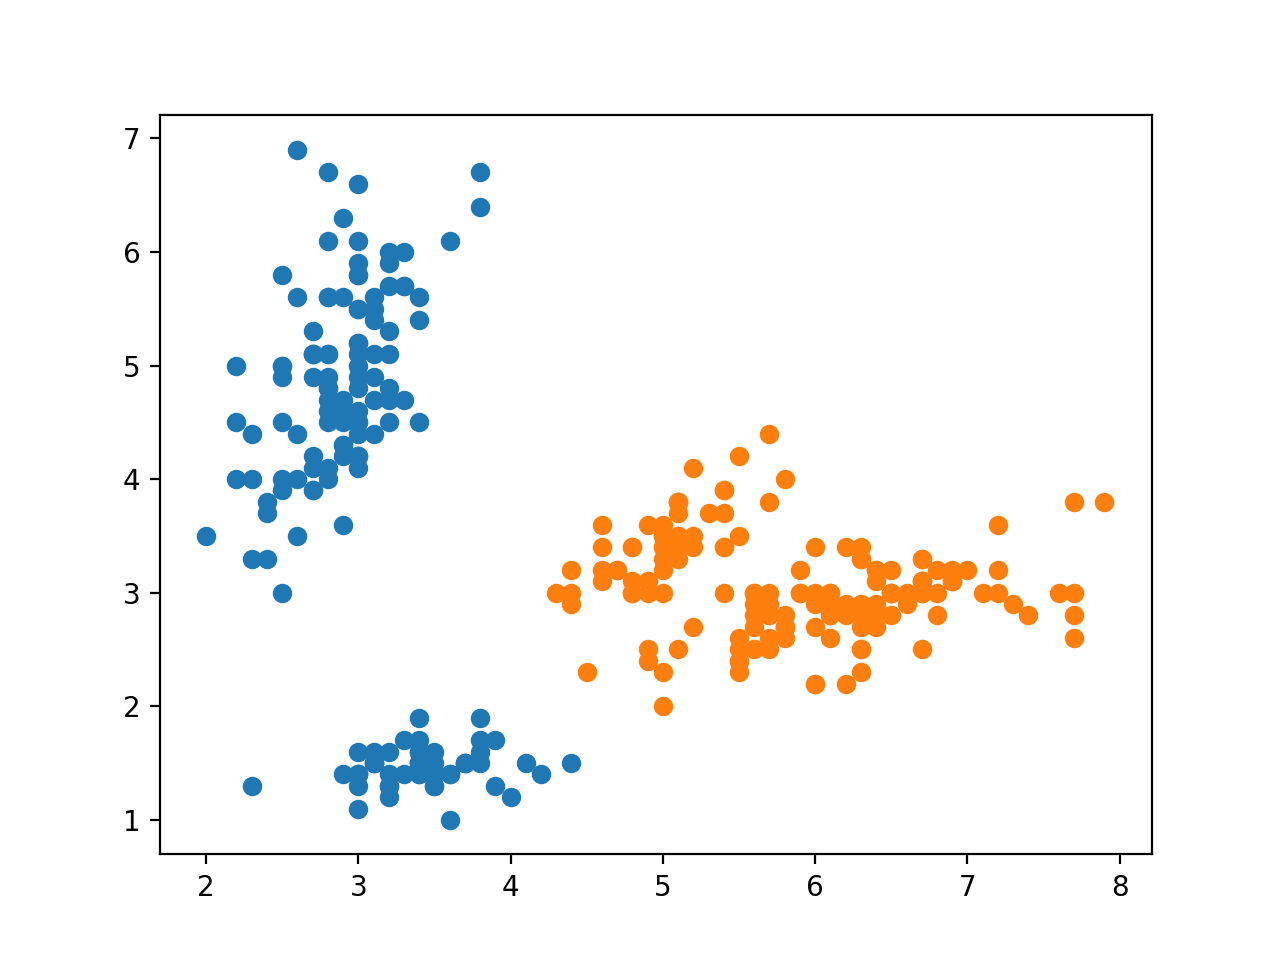

In [25]:
# load and normalize (mean zero, std one) data
# would be fun to try a few different things

n = 200

#X, y = create_two_mvn(n, dim=10)

ds = datasets.load_iris()
X = ds.data
y = ds.target

# X, y = datasets.make_moons(n_samples=n, noise=.1)

#X = preprocessing.scale(X)
print(np.cov(X)[1,2])

print(X.shape)

plt.figure()
plt.hist(X[:,0], 25, histtype='step', lw=2)
plt.hist(X[:,1], 25, histtype='step', lw=2)
plt.hist(X[:,2], 25, histtype='step', lw=2)
plt.hist(X[:,3], 25, histtype='step', lw=2)
#plt.xlim([-3, 3])
plt.show()

plt.figure()
plt.scatter(X[:,1], X[:,2])
plt.scatter(X[:,0], X[:,1])
plt.show()

## Collecting all the parameters in one place

In [26]:
# tunable
n_components    = 2       # size of PCA and encoder latent spaces
num_epochs      = 1000
obeta           = 0.1     # weight of the orthogonality term
diagonal_weight = 0.0     # weight of the contractive term

# non-tunable
n_in      = X.shape[1]
Xt        = torch.tensor(X.astype(np.float32))
print(Xt.shape, n_in)

torch.Size([150, 4]) 4


### First, plain old PCA

In [27]:
pca = decomposition.PCA(n_components=n_components)
pca.fit(X)
z_pca = pca.transform(X)

### Next, a linear autoencoder

In [28]:
class LinearAE(nn.Module):
    
    def __init__(self, in_size, latent_size):
        super(LinearAE, self).__init__()
        
        self.encode = nn.Linear(in_size, latent_size)
        self.decode = nn.Linear(latent_size, in_size)
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [29]:
# non-orthogonal AE

model     = LinearAE(n_in, n_components)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss  = nn.MSELoss()

for i in range(num_epochs):
    
    # forward pass
    zp = model.encode(Xt)
    Xp = model.decode(zp)
    
    loss = mse_loss(Xt, Xp)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        print('Epoch: %4d // MSE Loss: %.2e' % (i+200, loss.item()))

Epoch:  200 // MSE Loss: 2.45e+01
Epoch:  400 // MSE Loss: 1.26e+01
Epoch:  600 // MSE Loss: 4.51e+00
Epoch:  800 // MSE Loss: 8.73e-01
Epoch: 1000 // MSE Loss: 3.20e-01


### Finally, let's see what a linear orthogonal autoencoder will do!

In [30]:
# orthogonal AE

ortho_model     = LinearAE(n_in, n_components)
ortho_optimizer = torch.optim.Adam(ortho_model.parameters(), lr=1e-3)

mse_loss_gpu = nn.MSELoss()

for i in range(num_epochs):
    
    # forward pass
    zp = ortho_model.encode(Xt)
    Xp = ortho_model.decode(zp)
    
    loss     = mse_loss_gpu(Xt, Xp)
    jac_loss = obeta * jacob.jg_loss(ortho_model.decode, zp, n_in, diagonal_weight=diagonal_weight)
    
    ortho_optimizer.zero_grad()
    loss.backward()
    jac_loss.backward()
    ortho_optimizer.step()
    
    if i % 200 == 0:
        print('Epoch: %4d // MSE Loss: %.2e // JAC Loss: %.2e' % (i+200, loss.item(), jac_loss.item()))

Epoch:  200 // MSE Loss: 3.16e+01 // JAC Loss: 7.90e-01
Epoch:  400 // MSE Loss: 1.32e+01 // JAC Loss: 1.67e-01
Epoch:  600 // MSE Loss: 5.29e+00 // JAC Loss: 5.30e-02
Epoch:  800 // MSE Loss: 1.55e+00 // JAC Loss: 6.23e-03
Epoch: 1000 // MSE Loss: 5.97e-01 // JAC Loss: 8.91e-04


<IPython.core.display.Javascript object>


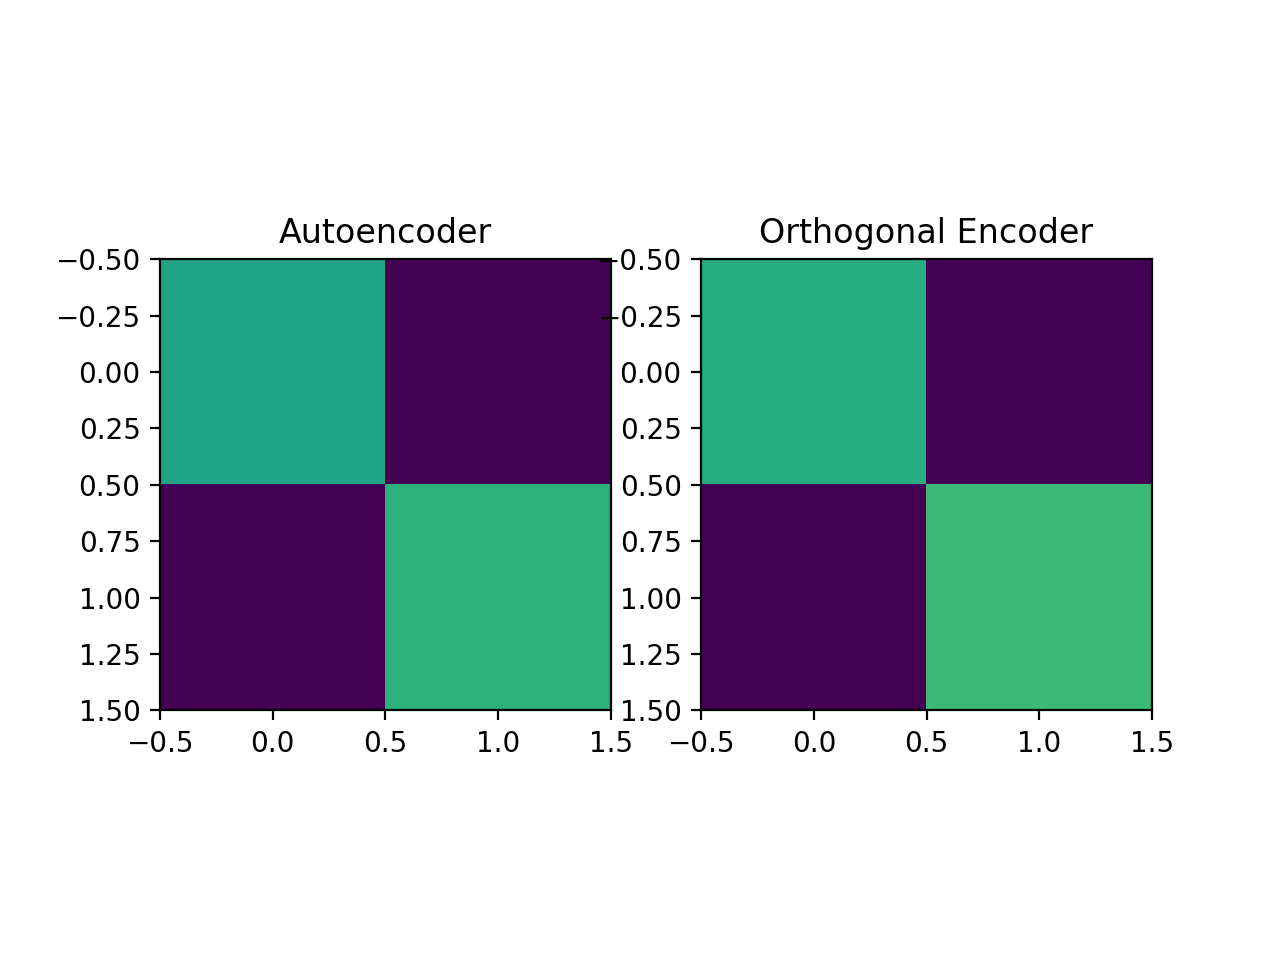

In [31]:
jg_accum_ae    = torch.zeros(n_components, n_components)
jg_accum_ortho = torch.zeros(n_components, n_components)

for zi in model.encode(Xt):
    jg_accum_ae += jacob.jacobian_grammian(model.decode, zi, n_in)

for zi in ortho_model.encode(Xt):
    jg_accum_ortho += jacob.jacobian_grammian(ortho_model.decode, zi, n_in)

plt.figure()
plt.subplot(121)
plt.title('Autoencoder')
plt.imshow(jg_accum_ae.detach().numpy(), vmin=0, vmax=300)
plt.subplot(122)
plt.title('Orthogonal Encoder')
plt.imshow(jg_accum_ortho.detach().numpy(), vmin=0, vmax=300)
plt.show()

## Plot the Results

In [32]:
def plot_latent_3d(trans_data, y, ax):

    # Reorder the labels to have colors matching the cluster results
    yc = np.choose(y, [1, 2, 0]).astype(np.float)
    ax.scatter(trans_data[:, 0], 
               trans_data[:, 1], 
               trans_data[:, 2], 
               c=yc, 
               cmap=plt.cm.nipy_spectral,
               edgecolor='k')

    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_zlim([-3,3])
    
    return

def plot_latent_2d(trans_data, y, ax):

    # Reorder the labels to have colors matching the cluster results
    yc = np.choose(y, [1, 2, 0]).astype(np.float)
    ax.scatter(trans_data[:, 0], 
               trans_data[:, 1],
               c=yc, 
               cmap=plt.cm.nipy_spectral,
               edgecolor='k')

    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    
    return

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklea

<IPython.core.display.Javascript object>


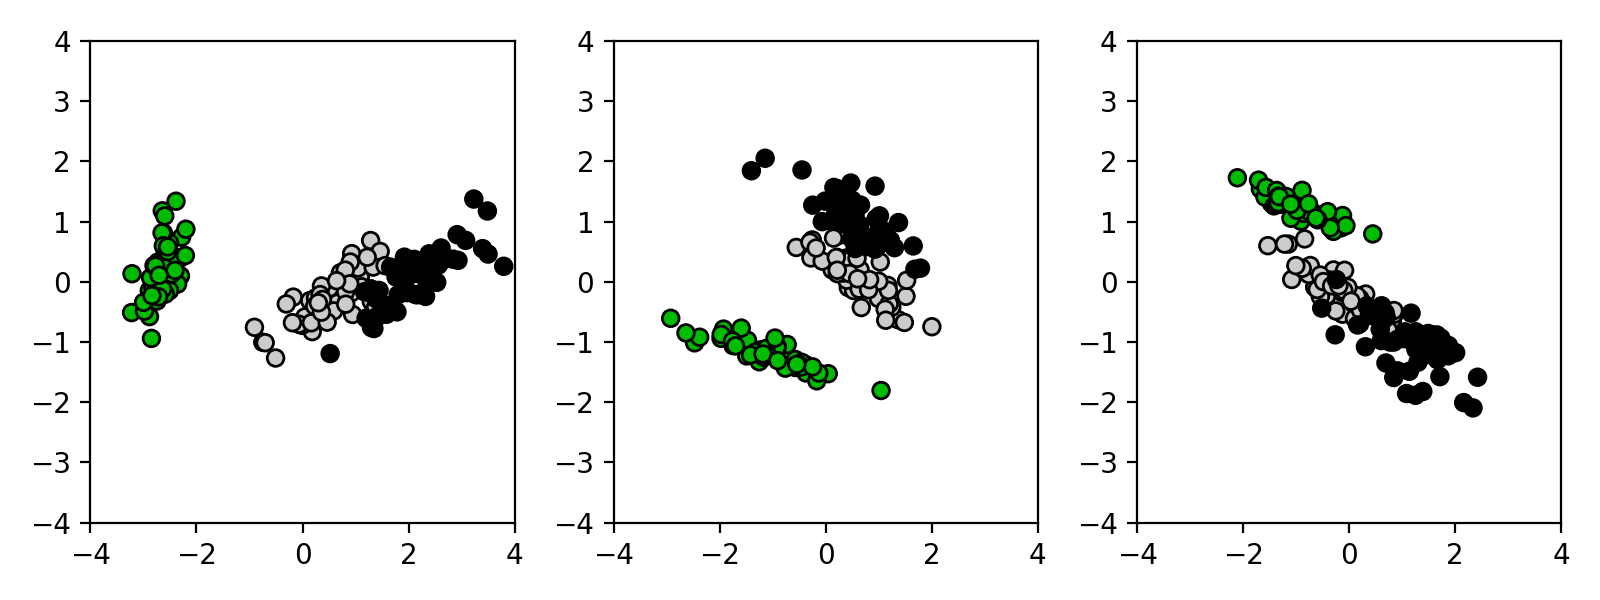

2d plots


In [34]:
z_ae  = model.encode(Xt).detach().numpy()
z_oae = ortho_model.encode(Xt).detach().numpy()

cz_ae  = z_ae - z_ae.mean(0)[None,:]
cz_oae = z_oae - z_oae.mean(0)[None,:]

cz_ae  = preprocessing.scale(z_ae)
cz_oae = preprocessing.scale(z_oae)

fig = plt.figure(figsize=(8, 3))

if n_components == 3:
    print('3d plots')
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')

    plot_latent_3d(z_pca, y, ax1)
    plot_latent_3d(z_ae - z_ae.mean(0)[None,:],  y, ax2)
    plot_latent_3d(z_oae - z_oae.mean(0)[None,:], y, ax3)
    
elif n_components == 2:
    print('2d plots')
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    plot_latent_2d(z_pca, y, ax1)
    plot_latent_2d(cz_ae,  y, ax2)
    plot_latent_2d(cz_oae, y, ax3)

plt.tight_layout()
plt.show()

In [13]:
# run multiple

In [14]:
# diags = [0.0, 0.1, 0.25, 0.5, 1.0]
# n_diags = len(diags)

# for i,diag in enumerate(diags):
    
#     print('diag:', diag, ' ', i+1, '/', n_diags)
    
#     om = LinearAE(n_in, 2)
#     oo = torch.optim.Adam(om.parameters(), lr=1e-3)
#     mse_loss = nn.MSELoss()

#     for e in range(1000):

#         # forward pass
#         zp = om.encode(Xt)
#         Xp = om.decode(zp)

#         loss     = mse_loss(Xt, Xp)
#         jac_loss = obeta * jacob.jg_loss(om.decode, zp, n_in, diagonal_weight=diag)

#         oo.zero_grad()
#         loss.backward()
#         jac_loss.backward()
#         oo.step()


#     print('MSE Loss: %.2e // JAC Loss: %.2e' % (loss.item(), jac_loss.item()))            
#     z_oae_d = om.encode(Xt).detach().numpy()
    
#     fig = plt.figure(figsize=(12, 4))
#     ax = fig.add_subplot(1, n_diags, i+1)
#     plt.title('diag=%.2f' % diag)
#     plot_latent(z_oae_d, y, ax)
#     plt.show()